<a href="https://colab.research.google.com/github/Ki-i/APRiL/blob/master/%E2%80%9CQ1a_ml0.84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
import random
import numpy as np
import torch
from scipy.io import loadmat
from torch.utils.data import Dataset

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
data = pd.read_excel("/content/drive/My Drive/shumo_data/Q1data.xlsx")
feats = [f for f in data if f not in [ "ID","数据集划分","kuozhang"]]#选择特征

def load_data(train_pos,dev_pos):
    data = pd.read_excel("/content/drive/My Drive/shumo_data/Q1data.xlsx")
    feats = [f for f in data if f not in ["ID", "数据集划分", "kuozhang"]]  # 选择特征

    print(feats)
    # 创建MinMaxScaler对象
    scaler = MinMaxScaler()
    # 对特征进行最小-最大归一化
    data[feats] = scaler.fit_transform(data[feats])
    # 使用条件索引划分数据

    df_train = data[data['数据集划分'] == '训练']

    X = df_train.drop(columns=["ID", "数据集划分", "kuozhang"])
    y = df_train["kuozhang"]

    # 将数据集分为训练集和测试集
    X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.2, random_state=30)
        # 使用 iloc 选择除第一行以外的所有行
    # 使用 .values 方法将新 DataFrame 转换为 NumPy 数组
    X_train = X_train.iloc[1:].values
    X_dev = X_dev.iloc[1:].values
    y_train = y_train.iloc[1:].values
    y_dev = y_dev.iloc[1:].values
    x_train, y_train, x_dev, y_dev = sample(X_train, y_train, X_dev, y_dev, train_pos=train_pos,
                                            train_neg=train_pos,dev_pos=dev_pos,dev_neg=dev_pos)
    # x_dev, y_dev = sample(x_dev, y_dev,positive_num=2,nagetive_num=2,vaild_class=valid_class,train=False,only_invalid=False)
    return x_train, y_train, x_dev, y_dev


def sample(x_data_raw, y_data_raw, x_dev, y_dev, train_pos=3, train_neg=3,dev_neg=3,dev_pos=3):
    print("train_pos",train_pos,"dev_pos",dev_pos)
    x_data = []
    y_data = []
    x_dev_data = []
    y_dev_data = []
    class_list = np.unique(y_data_raw)
    p_count = 0
    n_count = 0
    for class_i in class_list:
        x_i = x_data_raw[y_data_raw == class_i]
        test_i = x_dev[y_dev == class_i]
        x_j = x_data_raw[y_data_raw != class_i]
        print("x_i_len", class_i, len(x_i))
        for x in x_i:
            print(len(x_i),train_pos)

            indexList = random.sample(range(len(x_i)), train_pos)
            for index in indexList:
                print("index",index)
                print(x_i.shape,index,type(x_i))
                x_same_class = x_i[index]
                positive_sample = [x, x_same_class]
                x_data.append(positive_sample)
                y_data.append([1])
                p_count += 1

            indexList = random.sample(range(len(x_j)), train_neg)
            for index in indexList:
                x_other_class = x_j[index]
                negative_sample = [x, x_other_class]
                x_data.append(negative_sample)
                y_data.append([0])
                n_count += 1

        for test_x in test_i:
            indexList = random.sample(range(len(x_i)), int(dev_pos))
            for index in indexList:
                x_same_class = x_i[index]
                positive_sample = [test_x, x_same_class]
                x_dev_data.append(positive_sample)
                y_dev_data.append([1])
                p_count += 1
            indexList = random.sample(range(len(x_j)), int(dev_neg))
            for index in indexList:
                x_other_class = x_j[index]
                negative_sample = [test_x, x_other_class]
                x_dev_data.append(negative_sample)
                y_dev_data.append([0])
                n_count += 1
    print("train", len(x_data), "train_negative", len(x_dev_data), p_count, n_count)
    # y_data = np.array(y_data)
    # state = np.random.get_state()
    # np.random.shuffle(x_data)
    # np.random.set_state(state)
    # np.random.shuffle(y_data)
    return x_data, y_data, x_dev_data, y_dev_data
class MyDataset(Dataset):
    def __init__(self, x, y):
        self.data = x
        self.label = y

    def __getitem__(self, idx):
        if self.label is None:
            return self.data[idx]
        return self.data[idx][0], self.data[idx][1], torch.tensor(self.label[idx], dtype=torch.float32)

    def __len__(self):
        return len(self.data)

In [21]:
from torch.nn import Module
from torch import nn
import torch
import torch.nn.functional as F
class DNNModel(Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.fc_1=nn.Linear(75,128)
        self.relu1 = nn.ReLU()  # 添加ReLU激活函数
        self.fc_2 = nn.Linear(128, 64)
        self.out = nn.Linear(64,1)
        self.dropout = nn.Dropout(p=0.2)

    def _forward(self,x):
        x=self.fc_1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.dropout(x)
        y=self.fc_2(x)
        return y

    def forward(self, x_1,x_2):
        y_1 = self._forward(x_1)
        y_2 = self._forward(x_2)
        # dis = torch.cat((y_1, y_2), dim=1)
        dis = torch.abs(y_1 - y_2)
        logits = self.out(dis)
        return logits

In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.optim import SGD

import torch.nn.functional as F
import numpy as np
import sys

lr=0.001
num_epoches=15000
use_GPU=1

train_pos=3
dev_pos=3

model_save_path='model_realimag_0910+0427static2_sample_2.pt' #模型保存路径

def loss_fn(logits, labels):
    loss_fn = F.binary_cross_entropy_with_logits(logits, labels)
    return loss_fn

#指定训练数据路径和参与训练的设备id
# append_list=[('data/0407_normal_单帧/0407static2_normal.mat','RFF')]

x_train, y_train, x_dev, y_dev = load_data(train_pos=train_pos,dev_pos=dev_pos)
print('train len', len(x_train), len(x_dev))
hparams ={
    'in_feature': len(x_train[0]),
    'out_feature': 200
}

train_dataset = MyDataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset,batch_size=64,drop_last=True)

dev_dataset = MyDataset(x_dev, y_dev)
dev_dataloader = DataLoader(dev_dataset,batch_size=64,drop_last=True)
l1_lambda=0.01
model = DNNModel()
# sgd = SGD([
#     {'params': model.parameters(), 'weight_decay': l1_lambda}
# ], lr=float(lr), weight_decay=0.001)

sgd = SGD(model.parameters(), lr=float(lr))
num_epoches = int(num_epoches)

if use_GPU:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
model.to(device)
min_loss=1
epoch_train_loss_list = []
epoch_dev_loss_list = []
epoch_train_acc_list = []
epoch_dev_acc_list = []
print("ooooooooooooooo")
for epoch in range(num_epoches):
    epoch_train_loss=0
    epoch_train_acc=0
    epoch_dev_loss=0
    epoch_dev_acc=0
    train_num=0
    dev_num=0
    for x_1,x_2,label in train_dataloader:
        s = len(label)
        # print(label)
        sgd.zero_grad()
        predict_y = model(x_1.to(device).float(), x_2.to(device).float())
        loss = loss_fn(predict_y, label.to(device))
        epoch_train_loss += loss.item()
        label_pred = np.where(predict_y.cpu().data.numpy() > 0, 1, 0)
        # print(label_pred)
        acc = np.sum(label_pred == label.numpy())
        epoch_train_acc += acc / s
        train_num += 1
        loss.backward()
        sgd.step()
    model.eval()
    with torch.no_grad():
        for x_1, x_2, label in dev_dataloader:
            s = len(label)
            sgd.zero_grad()
            predict_y = model(x_1.to(device).float(), x_2.to(device).float())
            loss = loss_fn(predict_y, label.to(device))
            epoch_dev_loss += loss.item()
            label_pred = np.where(predict_y.cpu().data.numpy() > 0, 1, 0)
            acc = np.sum(label_pred == label.numpy())
            epoch_dev_acc += acc / s
            dev_num += 1
    epoch_train_loss_list.append(epoch_train_loss / train_num)
    epoch_dev_loss_list.append(epoch_dev_loss / dev_num)
    epoch_train_acc_list.append(epoch_train_acc / train_num)
    epoch_dev_acc_list.append(epoch_dev_acc / dev_num)
    dev_loss =epoch_dev_loss / dev_num
    # if dev_loss <min_loss:
    #     print('save')
    #     min_loss = dev_loss
    #     torch.save(model, model_save_path)
    print("epoch11 {:.4f} train acc: {:.4f},train loss: {:.4f}, dev acc: {:.4f}, dev loss: {:.4f}".format(epoch,
                                                                                                        epoch_train_acc / train_num,
                                                                                                        epoch_train_loss / train_num,
                                                                                                        epoch_dev_acc / dev_num,
                                                                                                        epoch_dev_loss / dev_num))



t = np.arange(1, len(epoch_train_acc_list) + 1)
acc_plot = plt.subplot(1,2, 1)
plt.title('acc')
plt.plot(t, epoch_train_acc_list, color='turquoise', label='train acc')
plt.plot(t, epoch_dev_acc_list, color='dodgerblue', label='dev acc')
plt.legend(loc='upper left')
plt.grid(alpha=0.4,linestyle='--',)
loss_plot = plt.subplot(1, 2, 2)
plt.title('loss ')
plt.plot(t, epoch_train_loss_list, color='turquoise', label='train loss')
plt.plot(t, epoch_dev_acc_list, color='dodgerblue', label='dev loss')
plt.legend(loc='upper right')
plt.grid(alpha=0.4,linestyle='--',)
plt.savefig('ensem-0114_train_info3.jpg', dpi=300)

['90天mRS', '流水号', '年龄', '性别', '脑出血前mRS评分', '高血压病史', '卒中病史', '糖尿病史', '房颤史', '冠心病史', '吸烟史', '饮酒史', '发病到首次影像检查时间间隔', '脑室引流', '止血治疗', '降颅压治疗', '降压治疗', '镇静、镇痛治疗', '止吐护胃', '营养神经', '高压', '低压', 'HM_volume1', 'HM_ACA_R_Ratio', 'HM_MCA_R_Ratio', 'HM_PCA_R_Ratio', 'HM_Pons_Medulla_R_Ratio', 'HM_Cerebellum_R_Ratio', 'HM_ACA_L_Ratio', 'HM_MCA_L_Ratio', 'HM_PCA_L_Ratio', 'HM_Pons_Medulla_L_Ratio', 'HM_Cerebellum_L_Ratio', 'ED_volume', 'ED_ACA_R_Ratio', 'ED_MCA_R_Ratio', 'ED_PCA_R_Ratio', 'ED_Pons_Medulla_R_Ratio', 'ED_Cerebellum_R_Ratio', 'ED_ACA_L_Ratio', 'ED_MCA_L_Ratio', 'ED_PCA_L_Ratio', 'ED_Pons_Medulla_L_Ratio', 'ED_Cerebellum_L_Ratio', 'original_shape_Elongation', 'original_shape_Flatness', 'original_shape_LeastAxisLength', 'original_shape_MajorAxisLength', 'original_shape_Maximum2DDiameterColumn', 'original_shape_Maximum2DDiameterRow', 'original_shape_Maximum2DDiameterSlice', 'original_shape_Maximum3DDiameter', 'original_shape_MeshVolume', 'original_shape_MinorAxisLength', 'original_shape_Sp

In [27]:
print(label_pred.T)
print(label.numpy().T)

[[1 1 1 0 1 1 1 1 1 0 0 0 0 1 1 0 0 0 1 1 1 1 0 0 1 1 1 0 0 1 1 1 1 0 0 1
  0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 1 0 1 0]]
[[1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0.
  1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0.
  1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0.]]


In [ ]:
data[['高压', '低压']] = data['血压'].str.split('/', expand=True).astype(int)
data.head()  #展示数据集前5个
data['性别'] = data['性别'].replace({'男': 1, '女': 0})
feats = [f for f in data if f not in [ "ID","90天mRS","血压","数据集划分"]]#选择特征
print(feats)

# 创建MinMaxScaler对象
scaler = MinMaxScaler()

# 对特征进行最小-最大归一化
data[feats] = scaler.fit_transform(data[feats])

['年龄', '性别', '脑出血前mRS评分', '高血压病史', '卒中病史', '糖尿病史', '房颤史', '冠心病史', '吸烟史', '饮酒史', '发病到首次影像检查时间间隔', '脑室引流', '止血治疗', '降颅压治疗', '降压治疗', '镇静、镇痛治疗', '止吐护胃', '营养神经', 'HM_volume', 'HM_ACA_R_Ratio', 'HM_MCA_R_Ratio', 'HM_PCA_R_Ratio', 'HM_Pons_Medulla_R_Ratio', 'HM_Cerebellum_R_Ratio', 'HM_ACA_L_Ratio', 'HM_MCA_L_Ratio', 'HM_PCA_L_Ratio', 'HM_Pons_Medulla_L_Ratio', 'HM_Cerebellum_L_Ratio', 'ED_volume', 'ED_ACA_R_Ratio', 'ED_MCA_R_Ratio', 'ED_PCA_R_Ratio', 'ED_Pons_Medulla_R_Ratio', 'ED_Cerebellum_R_Ratio', 'ED_ACA_L_Ratio', 'ED_MCA_L_Ratio', 'ED_PCA_L_Ratio', 'ED_Pons_Medulla_L_Ratio', 'ED_Cerebellum_L_Ratio', '高压', '低压']


In [ ]:
# 使用条件索引划分数据
df_train = data[data['数据集划分'] == '训练']
df_test = data[data['数据集划分'] == '测试1']
# df_train.head()
df_test.head()

,ID,90天mRS,数据集划分,年龄,性别,脑出血前mRS评分,高血压病史,卒中病史,糖尿病史,房颤史,...,ED_PCA_R_Ratio,ED_Pons_Medulla_R_Ratio,ED_Cerebellum_R_Ratio,ED_ACA_L_Ratio,ED_MCA_L_Ratio,ED_PCA_L_Ratio,ED_Pons_Medulla_L_Ratio,ED_Cerebellum_L_Ratio,高压,低压
100,sub101,NaN,测试1,0.712121,0.0,0.000000,1.0,1.0,1.0,0.0,...,0.173469,0.000000,0.0,0.000000,0.00,0.000000,0.0,0.0,0.871429,0.777778
101,sub102,NaN,测试1,0.606061,1.0,0.333333,1.0,1.0,0.0,0.0,...,0.122449,0.000000,0.0,0.000000,0.00,0.000000,0.0,0.0,0.400000,0.488889
102,sub103,NaN,测试1,0.515152,1.0,1.000000,1.0,1.0,0.0,0.0,...,0.000000,0.000000,0.0,0.032967,0.94,0.047619,0.0,0.0,0.300000,0.511111
103,sub104,NaN,测试1,0.181818,1.0,0.000000,1.0,0.0,0.0,0.0,...,0.224490,0.017857,0.0,0.000000,0.00,0.000000,0.0,0.0,0.307143,0.600000
104,sub105,NaN,测试1,0.318182,1.0,0.000000,1.0,1.0,0.0,0.0,...,0.000000,0.000000,0.0,0.879121,0.20,0.000000,0.0,0.0,0.364286,0.455556


In [ ]:
# 提取特征列（排除目标列）
X = df_train .drop(columns=["ID","90天mRS","血压","数据集划分"])

# 提取目标列
y = df_train["90天mRS"]

# 将数据集分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(y_test)
print(y_test.size)

83    1.0
53    3.0
70    1.0
45    2.0
44    1.0
39    1.0
22    1.0
80    3.0
10    1.0
0     4.0
18    1.0
30    4.0
73    0.0
33    4.0
90    2.0
4     3.0
76    6.0
77    1.0
12    1.0
31    0.0
Name: 90天mRS, dtype: float64
20


In [ ]:
t = list(range(1, num_epochs + 1, step))
# print(len(t))
# print(X)


# 划分数据集为训练集和测试集

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

# 将数据转换为PyTorch张量
X_train = torch.Tensor(X_train.values)
y_train = torch.Tensor(y_train.values).view(-1, 1)  # 将目标数据调整为列向量
X_test = torch.Tensor(X_test.values)
y_test = torch.Tensor(y_test.values).view(-1, 1)  # 将目标数据调整为列向量

X_train=torch.reshape(X_train,(X_train.shape[0], 1, X_train.shape[1]))
X_test=torch.reshape(X_test,(X_test.shape[0], 1, X_test.shape[1]))

# X_train=torch.reshape(X_train,(1,X_train.shape[0], X_train.shape[1]))
# X_test=torch.reshape(X_test,(1,X_test.shape[0],  X_test.shape[1]))

print(X_train.size())
print(X_test.size())

torch.Size([80, 1, 42])
torch.Size([20, 1, 42])


In [ ]:
print(X_train)

tensor([[[0.1515, 1.0000, 0.0000,  ..., 0.0000, 0.5714, 0.7889]],

        [[0.4091, 1.0000, 0.0000,  ..., 0.0000, 0.3714, 0.5556]],

        [[0.7879, 0.0000, 0.0000,  ..., 1.0000, 0.3714, 0.3444]],

        ...,

        [[0.7273, 0.0000, 0.0000,  ..., 0.0000, 0.1500, 0.2778]],

        [[0.1667, 1.0000, 0.0000,  ..., 0.0000, 0.5714, 0.5778]],

        [[0.3182, 1.0000, 0.0000,  ..., 0.0000, 0.1929, 0.4667]]])


流式输出内容被截断，只能显示最后 5000 行内容。
Epoch [5001/10000], train_Loss: 0.0003887911734636873,test_Loss:21.977039337158203, r2_store:-0.3559820472824524
Epoch [5002/10000], train_Loss: 0.00038885511457920074,test_Loss:21.964218139648438, r2_store:-0.35505813572451306
Epoch [5003/10000], train_Loss: 0.00038938195211812854,test_Loss:21.976675033569336, r2_store:-0.3560033716670272
Epoch [5004/10000], train_Loss: 0.00039052829379215837,test_Loss:21.965417861938477, r2_store:-0.354879935972644
Epoch [5005/10000], train_Loss: 0.0003921288007404655,test_Loss:21.980939865112305, r2_store:-0.35601155081690194
Epoch [5006/10000], train_Loss: 0.000394180096918717,test_Loss:21.96817398071289, r2_store:-0.35466517691842303
Epoch [5007/10000], train_Loss: 0.0003987882810179144,test_Loss:21.985828399658203, r2_store:-0.3561418830624634
Epoch [5008/10000], train_Loss: 0.0004055732861161232,test_Loss:21.96488380432129, r2_store:-0.35447684527230106
Epoch [5009/10000], train_Loss: 0.000414711277699098,test_Loss:21.

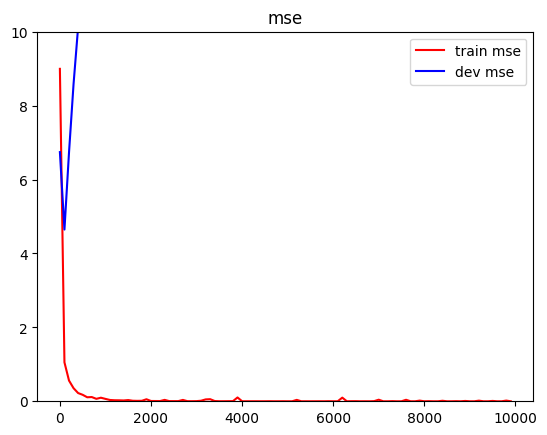

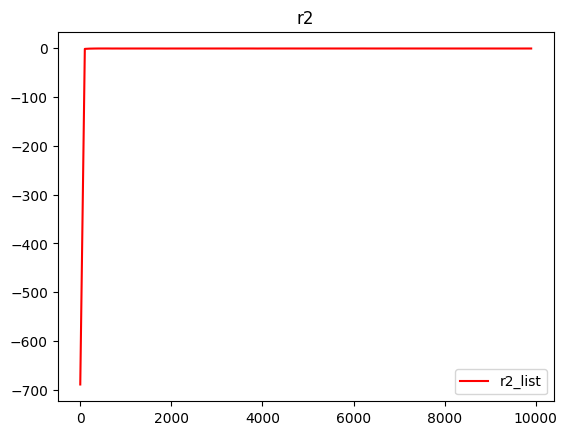

In [ ]:


# 定义CNN模型
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(1,16,5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        # self.conv2 = nn.Conv1d(16,32,2)
        # self.fc1 = nn.Linear(32 * 64, 64)  # 根据输入大小调整线性层的输入大小
        self.flat1 = nn.Flatten()
        self.fc2 = nn.Linear(152, 1)  # 输出一个连续的回归值
        self.dropout = nn.Dropout(p=0.5)  # dropout训练

    def forward(self, x):
        y = self.conv1(x)
        # print(y.size())
        y = self.relu1(y)
        # print(y.size())
        y = self.pool1(y)
        # print(y.size())
        y = self.flat1(y)
        y = self.dropout(y)
        # print(y.size())
        y = self.fc2(y)
        # print(y.size())
        y = self.dropout(y)
        # y = self.conv2(y)
        # y = self.relu2(y)
        # y = self.pool2(y)
        # y = self.conv3(y)
        # y = self.relu3(y)
        # y = self.pool3(y)
        return y

#两层卷积层，后面接一个全连接层
class D1CNN(nn.Module):
    def __init__(self):
        super(D1CNN, self).__init__()
        self.model1 = nn.Sequential(
        	#输入通道一定为1，输出通道为卷积核的个数，2为卷积核的大小（实际为一个[1,2]大小的卷积核）
            nn.Conv1d(1, 8, 2),
            nn.Sigmoid(),
            nn.MaxPool1d(2),  # 输出大小：torch.Size([128, 16, 5])
            nn.Conv1d(8, 16, 2),
            nn.Sigmoid(),
            nn.MaxPool1d(4),  # 输出大小：torch.Size([128, 32, 1])
            nn.Flatten(),  # 输出大小：torch.Size([128, 32])
        )
        self.model2 = nn.Sequential(
            nn.Linear(in_features=128, out_features=1, bias=True),
            nn.Sigmoid(),
        )
        self.dropout = nn.Dropout(p=0.3)  # dropout训练
    def forward(self, input):
        x = self.model1(input)
        x = self.dropout(x)
        # print(x.size())
        x = self.model2(x)
        x = self.dropout(x)
        return x


# 定义神经网络模型
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu1 = nn.ReLU()  # 添加ReLU激活函数
        # self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()  # 添加ReLU激活函数
        self.fc3 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(p=0.3)  # dropout训练


    def forward(self, x):
        x = self.fc1(x) # 应用ReLU激活函数
        x = self.dropout(x)
        # x = self.relu2(self.fc2(x))  # 应用ReLU激活函数
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.dropout(x)
        return x

# # 定义神经网络模型
# class Net(nn.Module):
#     def __init__(self, input_size):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(input_size, 64)
#         self.fc2 = nn.Linear(64, 32)
#         self.fc3 = nn.Linear(32, 1)
#         self.dropout = nn.Dropout(p=0.3)  # dropout训练

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = self.fc3(x)  # 在回归中，输出层通常不使用激活函数
#         x = self.dropout(x)
#         return x

# 创建模型实例
input_size = X_train.shape[1]
# model = Net(input_size)
model = CNNModel()
# model= D1CNN()
# 定义均方误差损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.02)

# 训练模型
num_epochs = 10000
num_plot=100
train_plot=[]
dev_plot=[]
r2_list=[]
step=int(num_epochs/num_plot)
for epoch in range(num_epochs):
    # print(X_train.size())
    # 前向传播
    outputs = model(X_train)
    # print(X_train.size())
    loss = criterion(outputs, y_train)

    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # 测试模型
    model.eval()
    # print("1")
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        r2 = r2_score(test_outputs, y_test)
        print(f'Epoch [{epoch + 1}/{num_epochs}], train_Loss: {loss.item()},test_Loss:{test_loss.item()}, r2_store:{r2}')
        if epoch%step==0:
          train_plot.append(loss.item())
          dev_plot.append(test_loss.item())
          r2_list.append(r2)
    # print(f'Test Mean Squared Error (MSE): {test_loss.item()}')

t = list(range(1, num_epochs + 1, step))
plt.title('mse')
plt.plot(t, train_plot, color='red', label='train mse')
plt.plot(t, dev_plot, color='blue', label='dev mse')

plt.legend()
plt.ylim(0,10)
plt.show()

plt.title('r2')
plt.plot(t, r2_list, color='red', label='r2_list')
plt.legend()
# plt.ylim(0,10)
plt.show()



#### 神经网络


流式输出内容被截断，只能显示最后 5000 行内容。
torch.Size([80, 42])
Epoch [7501/10000], train_Loss: 2.548709398912663e-13,test_Loss:5.288077354431152, r2_store:0.3242450056353182
torch.Size([80, 42])
Epoch [7502/10000], train_Loss: 4.1459704050970936e-13,test_Loss:5.288077354431152, r2_store:0.3242450382197458
torch.Size([80, 42])
Epoch [7503/10000], train_Loss: 3.2171045883690186e-13,test_Loss:5.288077354431152, r2_store:0.32424499120464545
torch.Size([80, 42])
Epoch [7504/10000], train_Loss: 3.0187628113388654e-13,test_Loss:5.288078784942627, r2_store:0.3242449920244648
torch.Size([80, 42])
Epoch [7505/10000], train_Loss: 4.586204463072341e-13,test_Loss:5.288078784942627, r2_store:0.32424501765434
torch.Size([80, 42])
Epoch [7506/10000], train_Loss: 3.2450414967979957e-13,test_Loss:5.288079261779785, r2_store:0.32424497161351373
torch.Size([80, 42])
Epoch [7507/10000], train_Loss: 2.887325253018991e-13,test_Loss:5.288079738616943, r2_store:0.3242449582705693
torch.Size([80, 42])
Epoch [7508/10000], trai

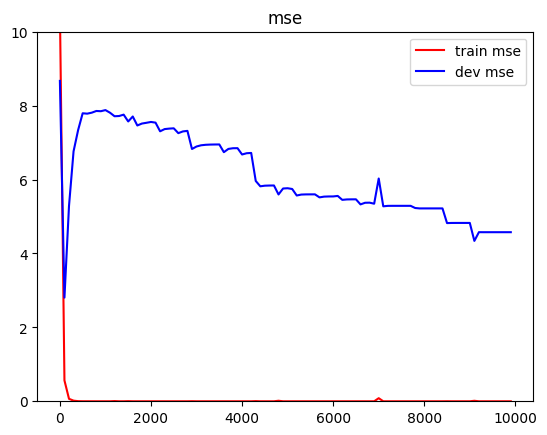

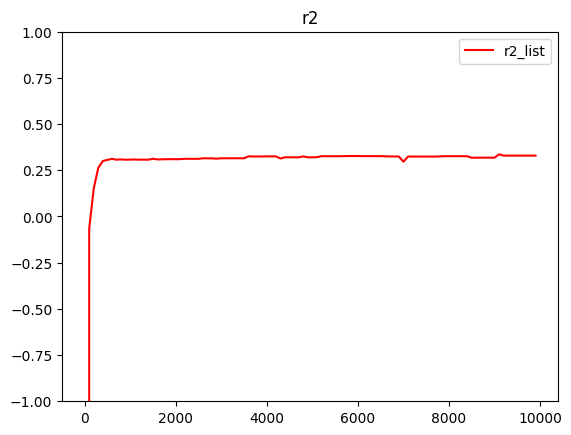

In [ ]:
# 划分数据集为训练集和测试集

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

# 将数据转换为PyTorch张量
X_train = torch.Tensor(X_train.values)
y_train = torch.Tensor(y_train.values).view(-1, 1)  # 将目标数据调整为列向量
X_test = torch.Tensor(X_test.values)
y_test = torch.Tensor(y_test.values).view(-1, 1)  # 将目标数据调整为列向量

# 定义CNN模型
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 64, 64)  # 根据输入大小调整线性层的输入大小
        self.fc2 = nn.Linear(64, 1)  # 输出一个连续的回归值

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# # 定义神经网络模型
# class Net(nn.Module):
#     def __init__(self, input_size):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(input_size, 64)
#         self.relu1 = nn.ReLU()  # 添加ReLU激活函数
#         self.fc2 = nn.Linear(64, 32)
#         self.relu2 = nn.ReLU()  # 添加ReLU激活函数
#         self.fc3 = nn.Linear(32, 1)
#         self.dropout = nn.Dropout(p=0.3)  # dropout训练


#     def forward(self, x):
#         x = self.fc1(x) # 应用ReLU激活函数
#         x = self.dropout(x)
#         x = self.relu2(self.fc2(x))  # 应用ReLU激活函数
#         x = self.dropout(x)
#         x = self.fc3(x)
#         x = self.dropout(x)
#         return x

# 定义神经网络模型
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(p=0.3)  # dropout训练

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  # 在回归中，输出层通常不使用激活函数
        x = self.dropout(x)
        return x

# 创建模型实例
input_size = X_train.shape[1]
model = Net(input_size)
# model = CNNModel()

# 定义均方误差损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 训练模型
num_epochs = 10000
num_plot=100
train_plot=[]
dev_plot=[]
r2_list=[]
step=int(num_epochs/num_plot)
for epoch in range(num_epochs):
    print(X_train.size())
    # 前向传播
    outputs = model(X_train)

    loss = criterion(outputs, y_train)

    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # 测试模型
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        r2 = r2_score(test_outputs, y_test)
        print(f'Epoch [{epoch + 1}/{num_epochs}], train_Loss: {loss.item()},test_Loss:{test_loss.item()}, r2_store:{r2}')
        if epoch%step==0:
          train_plot.append(loss.item())
          dev_plot.append(test_loss.item())
          r2_list.append(r2)
    # print(f'Test Mean Squared Error (MSE): {test_loss.item()}')

t = list(range(1, num_epochs + 1, step))
plt.title('mse')
plt.plot(t, train_plot, color='red', label='train mse')
plt.plot(t, dev_plot, color='blue', label='dev mse')

plt.legend()
plt.ylim(0,10)
plt.show()

plt.title('r2')
plt.plot(t, r2_list, color='red', label='r2_list')
plt.ylim(-1,1)
plt.legend()
# plt.ylim(0,10)
plt.show()




In [ ]:
print(dev_plot)

[14555528.0, 173109.1875, 76168.03125, 29948.806640625, 8589.5595703125, 2638.425537109375, 1654.9788818359375, 717.1921997070312, 458.5187072753906, 367.20068359375, 304.4831848144531, 288.59722900390625, 274.01495361328125, 263.7897033691406, 255.0748748779297, 245.58154296875, 237.83261108398438, 230.21255493164062, 223.54373168945312, 217.6713104248047, 212.16732788085938, 207.21591186523438, 202.74966430664062, 198.65478515625, 194.9128875732422, 191.43751525878906, 188.15933227539062, 185.11720275878906, 182.42453002929688, 179.930908203125, 177.5941619873047, 175.4064483642578, 173.32357788085938, 171.25523376464844, 169.3544464111328, 167.8666534423828, 167.20968627929688, 166.67562866210938, 167.2655029296875, 168.36402893066406, 168.9976348876953, 169.02359008789062, 168.5924072265625, 167.89549255371094, 167.03884887695312, 166.19561767578125, 165.4131317138672, 164.68319702148438, 164.0052032470703, 163.36550903320312, 162.74501037597656, 162.14053344726562, 161.55233764648

In [ ]:
print(train_plot)

[268339.78125, 493039.5625, 53700.2265625, 37000.6171875, 12740.8876953125, 4199.96142578125, 1431.60546875, 576.1301879882812, 192.1226806640625, 78.60606384277344, 38.97517776489258, 19.69007682800293, 14.177583694458008, 12.247934341430664, 10.952315330505371, 9.967523574829102, 8.959409713745117, 8.136252403259277, 7.478572845458984, 6.938460350036621, 6.492982387542725, 6.127853870391846, 5.8306684494018555, 5.586463451385498, 5.384247303009033, 5.209819316864014, 5.059847354888916, 4.928833961486816, 4.766226768493652, 4.60635232925415, 4.4631781578063965, 4.339550971984863, 4.229368686676025, 4.110690116882324, 3.993617296218872, 3.875629425048828, 3.7701072692871094, 3.6736724376678467, 3.6075024604797363, 3.555830717086792, 3.5133235454559326, 3.476522445678711, 3.4435126781463623, 3.4132347106933594, 3.383958339691162, 3.35683012008667, 3.3317809104919434, 3.3083863258361816, 3.2863357067108154, 3.265479326248169, 3.2467846870422363, 3.229179859161377, 3.212366819381714, 3.19

In [ ]:
test_outputs

tensor([[ 1.1013],
        [ 1.9285],
        [ 2.7023],
        [ 2.5839],
        [ 0.2606],
        [-2.7002],
        [ 2.7023],
        [ 4.7595],
        [ 1.8779],
        [ 2.7023],
        [13.4137],
        [ 2.6441],
        [ 2.7023],
        [ 2.3672],
        [ 0.2155],
        [ 2.7023],
        [20.8173],
        [ 3.5201],
        [ 4.6199],
        [ 2.2991]])

In [ ]:
y_test

tensor([[1.],
        [3.],
        [1.],
        [2.],
        [1.],
        [1.],
        [1.],
        [3.],
        [1.],
        [4.],
        [1.],
        [4.],
        [0.],
        [4.],
        [2.],
        [3.],
        [6.],
        [1.],
        [1.],
        [0.]])

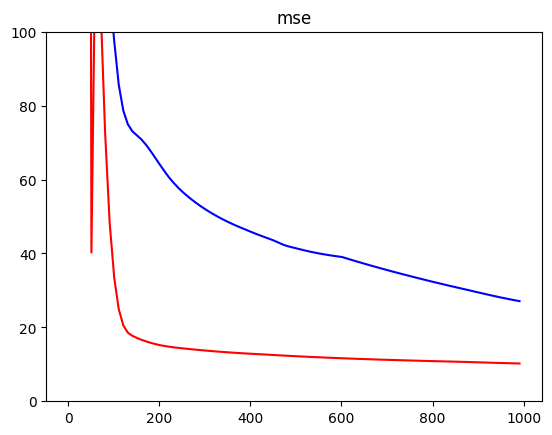

In [ ]:
t = list(range(1, num_epochs + 1, step))
plt.title('mse')
plt.plot(t, train_plot, color='red', label='train mse')
plt.plot(t, dev_plot, color='blue', label='dev mse')
plt.ylim(0,100)
plt.show()